# Requirements 

#### Based on TA's suggestion

- [x] pooled model
- [x] separate model
- [x] predictions
- [x] loo
- [ ] different prior, noninformative, change the prior? why did you select?
- [ ] sensitivity analysis, (change the prior)
- [ ] if loo indicates a bias, just report it


#### Based on Akki suggestion

- [ ] Description of the data, and the analysis problem
- [ ] Description of the model
- [ ] Description of the prior choices
- [ ] Stan code
- [ ] How Stan model is run
- [x] Convergence diagnostics (Rhat, divergences, neff)
- [ ] Posterior predictive checking
- [ ] Model comparison (e.g. with loo)
- [ ] Predictive performance assessment if applicable (e.g. classification accuracy)
- [ ] Potentially sensitivity analysis
- [ ] Discussion of problems, and potential improvements


#### Based on Rubrics
Is there an introduction?
- [ ] The introduction is inviting, presents an overview of the notebook. Information is relevant and presented in a logical order.

Is there a conclusion?
- [ ] The conclusion is clear

The structure and organization of the notebook
- [ ] The notebook presents a clear cohesive data analysis story, which is enjoyable to read

The structure and organization of the notebook
- [ ] The notebook presents a clear cohesive data analysis story, which is enjoyable to read

Accuracy of use of statistical terms
- [ ] Statistical terms are used accurately but sometimes lack clarity – Statistical terms are used accurately and with clarity

Description of the data, and the analysis problem
- [ ] Did you get a sense of what is the data and the analysis problem when they were first
introduced? Where and how might the author make the model description more clear?

Description of the model
- [ ] Did you get a sense of what is the model? Where and how might the author make the model description more clear?

Description of the prior choices
- [ ] Priors are listed and justified

Is Stan code included?
- [x] yes

Is code for how Stan model is run included?
- [x] yes

Is required convergence diagnostics (Rhat, divergences, neff) included?
- [ ] Required convergence diagnostic results shown and maning of the results is discussed

Is there posterior predictive checking? 
- [ ] yes

Is there a discussion of problems and potential improvements ?
- [ ] yes

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pystan
from psis import psisloo

In [62]:
def plot_trend(x_axis, y_axis, tlitle=''):
    plt.plot(x_axis, y_axis)
    plt.rcParams['figure.figsize'] = (10,5)
    z = np.polyfit(x_axis, y_axis, 1)
    trend = np.poly1d(z)
    plt.plot(x_axis, trend(x_axis), 'r--')
    plt.xticks(np.arange(2004, 2018, 1))
    plt.xlabel('year')
    plt.ylabel('deaths')
    plt.title(tlitle)
    plt.show()

# Data preprocessing

In [63]:
def process_data():    
    data_years = [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
    for year in data_years:
        data = pd.read_csv(
            'data/project/csv/tieliikenneonnettomuudet_{0}_hlo.csv'.format(year), 
            sep=';', 
            encoding = "ISO-8859-1"
        )

        death = data.loc[data['Seuraussel'] == 'kuollut']
        gender = death['Sukupuoli'].values

        male = np.count_nonzero(gender == 'M')
        female = np.count_nonzero(gender == 'N')

        data = {'year': [year], 'male': [male], 'female': [female]}
        df = pd.DataFrame(data)

        df = df[['year', 'male', 'female']]
        df.to_csv('data/data.csv', mode='a', header=None, index=False)

# process_data()

## Number of death due to road traffic accidents in Finland

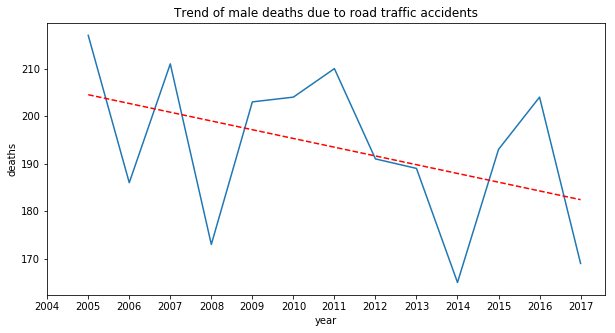

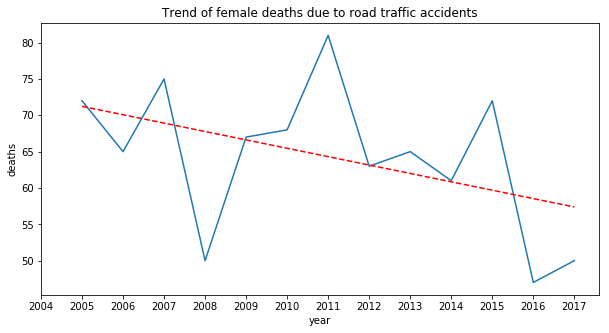

In [64]:
data = pd.read_csv('data/data.csv', sep = ',')
data['total']= data.iloc[:, 1:3].sum(axis=1)

years = data['year'].values
year_index = np.arange(1, len(years)+1)
male = data['male'].values
female = data['female'].values
total_deaths = data['total'].values
prediction_year = 14

mu = np.mean(total_deaths)
sigma = np.var(total_deaths)

# new params
N = len(total_deaths) * 2
num_groups = 2
x = np.arange(1, 3)
x = np.repeat(x, len(years))
group_indicator = np.arange(1, 3)
group_indicator = np.repeat(x, len(years))
combined = np.concatenate((male, female), axis=0)
plot_trend(years, male, 'Trend of male deaths due to road traffic accidents')
plot_trend(years, female, 'Trend of female deaths due to road traffic accidents')

### Prior calculations

We would like to apply a weakly-informative prior $N(0, \tau^{2})$ for the slope parameter $\beta$. It is very unlikely that the mean number of deaths changes more than 50% in one year. The approximate historical mean yearly for the number of total number deaths is $257.76$. Hence, we have to set $\tau$ so that the prior probability for $\beta$ being less than $−128.88$ or greater than $128.88$ is 0.01. Consequently, we have to calculate $\tau$ for *total number of deaths*, *male deaths* and *female deaths*.

#### Tau calculation for total death

In [199]:
# The value of dist.cdf(−128.9) should be 0.1/2 for the correct τ .
# mu = 257.8 => 257.8/2 = 128.9
from scipy.stats import norm
print(mu)
print(mu/2)

taus = []
for tau in np.arange(78, 79, 0.001):
    dist = norm(loc=0, scale=tau)
    val = dist.cdf(-128.9)
    if val <= 0.050002 and val >= 0.049998:
        taus.append(tau)
        print('tau:   \t', tau)
        print('val: \t',  val, '\n')
total_deaths_tau = taus[0]

257.7692307692308
128.8846153846154
tau:   	 78.36500000000174
val: 	 0.04999862400818712 

tau:   	 78.36600000000175
val: 	 0.05000078876859009 



#### Tau calculation for male death:

In [200]:
mu_male = np.mean(male)
print(mu_male)
print(mu_male/2)

taus = []
for tau in np.arange(58.5, 59, 0.001):
    dist = norm(loc=0, scale=tau)
    val = dist.cdf(-96.73)
    if val <= 0.050002 and val >= 0.049998:
        taus.append(tau)
        print('tau:   \t', tau)
        print('val: \t',  val, '\n')
# male tau: 58.8069

male_tau = taus[0]

193.46153846153845
96.73076923076923
tau:   	 58.806999999999285
val: 	 0.0499980835484519 

tau:   	 58.80799999999928
val: 	 0.05000096825233351 



####  Tau calculation for female death:

In [215]:
mu_female = np.mean(female)
print('mu_female', mu_female)
print('dev/2', mu_female/2)

taus = []
for tau in np.arange(19, 20, 0.001):
    dist = norm(loc=0, scale=tau)
    val = dist.cdf(-32.15)
    if val <= 0.05001 and val >= 0.04999:
        print('tau:   \t', tau)
        print('val: \t',  val, '\n')
        taus.append(tau)
female_tau = taus[0]

mu_female 64.3076923076923
dev/2 32.15384615384615
tau:   	 19.545000000000666
val: 	 0.04999295128373794 

tau:   	 19.546000000000667
val: 	 0.05000163043808533 



# Models

# Pooled Model

In [68]:
# POOLED MODEL
pooled_code = '''
data {
    int<lower=0> N;                 // number of data points
    real xpred;                     // year to predict
    vector[N] number_of_deaths;
    vector[N] years;
    real tau;
}

parameters {
    real alpha;
    real beta;
    real<lower=0> sigma;
}

transformed parameters{
    vector[N] mu;
    mu = alpha + (beta * years);
    
}

model {
    beta ~ normal(0, tau);
    
    for (i in 1:N)
        number_of_deaths[i] ~ normal(mu[i], sigma);
}

generated quantities {
    real new_pred;
    vector[N] log_lik;
    
    new_pred = normal_rng(alpha + beta * xpred, sigma);

    for (i in 1:N)
        log_lik[i] = normal_lpdf(number_of_deaths[i] | mu[i], sigma);
}
'''

sm = pystan.StanModel(model_code = pooled_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1784aba4ea0a680e9585d84ebbc55d57 NOW.
/Users/maksaddonayorov/.virtualenvs/bda/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/qn/_rqylh917b33tgzrfm1wy79h0000gn/T/tmp6pxzfula/stanfit4anon_model_1784aba4ea0a680e9585d84ebbc55d57_6090290540893298594.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


### Pooled model to predict the total number of deaths due to road traffic accidents

In [82]:
accidents_data = {
    'N': len(total_deaths),
    'number_of_deaths': total_deaths,
    'years': years,
    'xpred': 2018,
    'tau': total_deaths_tau
}

In [83]:
pooled_fit = sm.sampling(
    data = accidents_data,
    control = {'adapt_delta': 0.95, 'max_treedepth': 15}
)

In [84]:
def get_model_summary(model_fit):
    summary = model_fit.summary()
    summary = pd.DataFrame(
        summary['summary'], 
        columns=summary['summary_colnames'], 
        index=summary['summary_rownames']
    )

    log_lik = model_fit.extract(permuted=True)['log_lik']

    loo, loos, ks = psisloo(log_lik)
    print('PSIS-LOO value: {0}'.format(loo))

    S = np.shape(log_lik)[0]
    lppd = sum(np.log([1 / S * sum(np.exp(elem)) for elem in log_lik.T]))

    p_loocv = lppd - loo
    print('The effective number of parameters is: {0}'.format(p_loocv))

    print('K-hat values: {0}'.format(ks))

    return summary
    
get_model_summary(pooled_fit)

PSIS-LOO value: -61.025995215707354
The effective number of parameters is: 2.3645939839329984
K-hat values: [ 0.21890049  0.27516596  0.19690678  0.66372267  0.13903178  0.05655753
  0.25128348 -0.02791304  0.01550221  0.22020129  0.24900044  0.262158
  0.28376304]


,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
alpha,6202.011352,149.503623,4043.170983,-1393.703864,3656.782757,6026.878164,8587.218268,14630.916873,731.376127,1.009754
beta,-2.955833,0.074341,2.010552,-7.150095,-4.141688,-2.868383,-1.686806,0.820414,731.440189,1.009751
sigma,25.357265,0.211440,6.504286,16.585285,20.830862,24.098624,28.307510,41.790536,946.288354,1.002721
mu[1],275.565999,0.462633,13.990302,248.066096,266.858014,275.582827,283.863409,304.613164,914.494497,1.007854
mu[2],272.610166,0.390767,12.308012,248.437333,264.896610,272.640105,279.931201,297.763511,992.063579,1.007157
mu[3],269.654333,0.319486,10.739199,248.743395,262.842719,269.636610,276.247897,291.142271,1129.900829,1.006158
mu[4],266.698500,0.251205,9.341215,248.665039,260.837155,266.571409,272.442141,285.473205,1382.767792,1.004760
mu[5],263.742667,0.190162,8.201880,247.791674,258.618645,263.723780,268.760381,280.180739,1860.292898,1.002967
mu[6],260.786833,0.140249,7.440968,245.945577,256.201931,260.759337,265.378823,275.485117,2814.857917,1.001134
mu[7],257.831000,0.117920,7.179820,243.673970,253.436607,257.679462,262.226118,271.875180,3707.262975,1.000086


### Convergence diagnostics for the pooled model

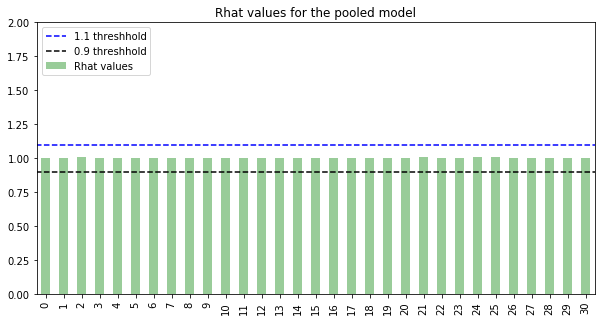

In [196]:
summary = pooled_fit.summary()
summary = pd.DataFrame(
    summary['summary'], 
    columns=summary['summary_colnames'], 
    index=summary['summary_rownames']
)

Rhat = summary['Rhat'].values

pd.Series(Rhat).plot(kind='bar', color='green', label='Rhat values', alpha=0.4)
plt.title('Rhat values for the pooled model')
plt.hlines(1.1, -1, 31, label='1.1 threshhold', linestyles='dashed', color='blue')
plt.hlines(0.9, -1, 31, label='0.9 threshhold', linestyles='dashed')
plt.ylim(0, 2)
plt.legend(loc='upper left')
plt.show()

From the histogram above, we can see that all the Rhat values are in a range between 0.9 and 1.1, which means that the model <b>has converged</b>.

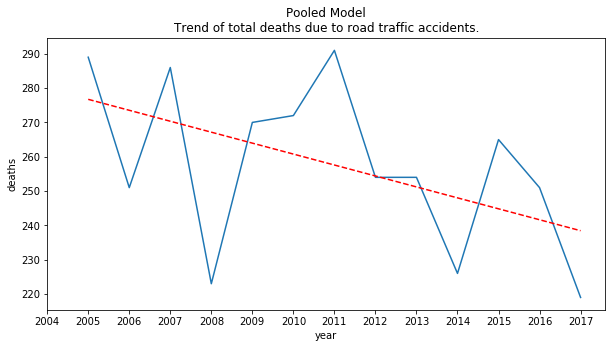

In [176]:
alpha = pooled_fit.extract()['alpha']
alpha = np.mean(alpha, axis=0)

beta = pooled_fit.extract()['beta']
beta = np.mean(beta, axis=0)

plt.plot(years, total_deaths)
plt.plot(years, [alpha + beta * i for i in range(2005, 2018)],  'r--')
plt.xticks(np.arange(2004, 2018, 1))
plt.xlabel('year')
plt.ylabel('deaths')
plt.title('Pooled Model\nTrend of total deaths due to road traffic accidents.')
plt.show()

In [86]:
def get_PSIS_LOO(model):
    """
    Get logposterior from the model, excluding the warmup perid
    Calculate the effective number of parameters p_eff
    Return PSIS-LOO estimates, p_eff
    """
    log_lik = model.extract(permuted=True)['log_lik']
    psis_loo, psis_loos_sep, k_values = psisloo(log_lik)
    
    lppd = np.sum(np.log(np.mean(np.exp(log_lik), axis=0)))
    p_eff = lppd - psis_loo
    
    return psis_loo, psis_loos_sep, k_values, p_eff

def quality_analysis(model):
    """
    Plots the resulting k_values
    """
    psis_loo, psis_loos_sep, k_values, p_eff = get_PSIS_LOO(model)
    
    print('PSIS-LOO estimate: {:.2f}\np_eff value: {:.2f}'.format(psis_loo, p_eff))
    
    pd.Series(k_values).plot(kind='bar', color='green', label='k-values', alpha=0.4)
    plt.title('K-values < 0.7: {0} out of {1}'.format(sum(k_values <= .7), len(k_values)))
    plt.hlines(0.7, -1, 30, label='0.7 threshhold', linestyles='dashed')
    plt.ylim(0, 1)
    plt.legend(loc='upper left')
    plt.show()

PSIS-LOO estimate: -61.03
p_eff value: 2.36


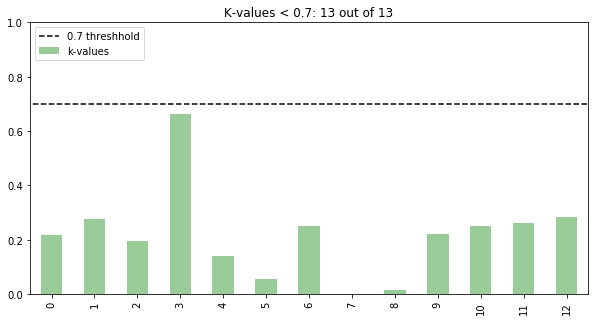

In [87]:
quality_analysis(pooled_fit)

### Predictions for 2018

In [88]:
def plot_perdiction_histogram(fit, xlim, xticks, bins, title='', ypred='new_pred'):
    y_pred = fit.extract()[ypred]
    plt.hist(y_pred, bins=bins, ec='white', alpha=0.7)
    plt.xlim(xlim[0], xlim[1])
    plt.xticks(np.arange(xlim[0], xlim[1], xticks))
    plt.title(title)
    plt.show()

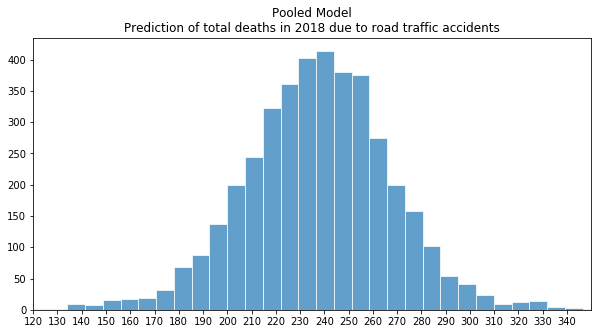

In [105]:
plot_perdiction_histogram(
    pooled_fit, 
    ypred='new_pred',
    xlim=[120, 350], 
    xticks=10, 
    bins=40,
    title='Pooled Model\nPrediction of total deaths in 2018 due to road traffic accidents'
)

## Separate Model

In [216]:
# SEPARATE MODEL
accidents_code = '''
data {
    int<lower=0> N;                 // number of data points
    int<lower=0> K;                 // number of groups
    int<lower=1,upper=K> group[N];  // group indicator
    real xpred;                     // year to predict
    vector[N] number_of_deaths;
    vector[N] years; 
    vector[K] tau;
}

parameters {
    vector[K] alpha;
    vector[K] beta;
    vector<lower=0>[K] sigma;
}

transformed parameters{
    vector[N] mu;
    for (i in 1:N)
        mu[i] = alpha[group[i]] + beta[group[i]] * years[i];
}

model {
    beta[1] ~ normal(0, tau[1]);
    beta[2] ~ normal(0, tau[2]); 
    
    for (i in 1:N)
        number_of_deaths[i] ~ normal(mu[i], sigma[group[i]]);
}

generated quantities {
    real male_pred;
    real female_pred;
    vector[N] log_lik;

    male_pred = normal_rng(alpha[1] + beta[1] * xpred, sigma[1]);
    female_pred = normal_rng(alpha[2] + beta[2] * xpred, sigma[2]);

    for (i in 1:N)
        log_lik[i] = normal_lpdf(number_of_deaths[i] | mu[i], sigma[group[i]]);
}
'''

sm = pystan.StanModel(model_code = accidents_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d2540ac1bb6c4020a6657c7d23ffd014 NOW.


In [217]:
accidents_data = {
    'N': N,
    'K': num_groups,
    'group': x,
    'number_of_deaths': combined,
    'years': list(years)*2,
    'xpred': 2018,
    'tau': [male_tau, female_tau]
}


separate_fit = sm.sampling(
    data = accidents_data,
    control = {'adapt_delta': 0.95, 'max_treedepth': 15}
)

### Separate model evaluation

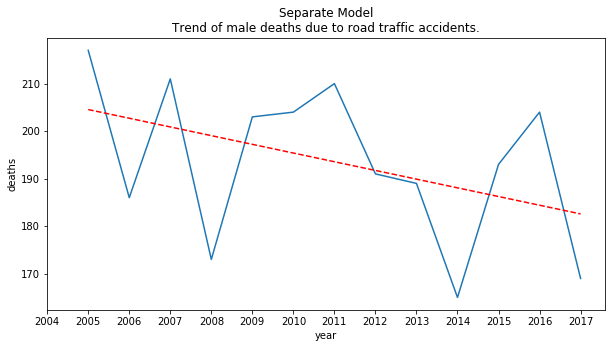

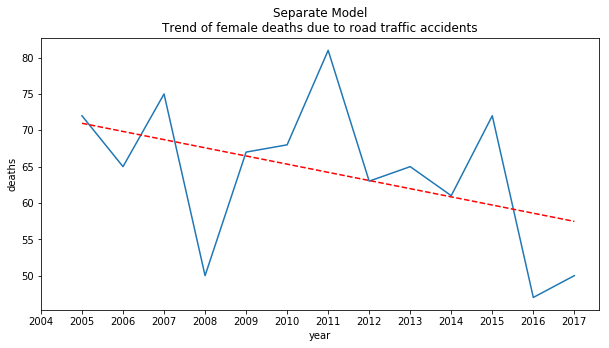

In [218]:
alpha = separate_fit.extract()['alpha']
alpha = np.mean(alpha, axis=0)

beta = separate_fit.extract()['beta']
beta = np.mean(beta, axis=0)

plt.plot(years, male)
plt.plot(years, [alpha[0] + beta[0] * i for i in range(2005, 2018)],  'r--')
plt.xticks(np.arange(2004, 2018, 1))
plt.xlabel('year')
plt.ylabel('deaths')
plt.title('Separate Model\nTrend of male deaths due to road traffic accidents.')
plt.show()

plt.plot(years, female)
plt.plot(years, [alpha[1] + beta[1] * i for i in range(2005, 2018)], 'r--')
plt.xticks(np.arange(2004, 2018, 1))
plt.xlabel('year')
plt.ylabel('deaths')
plt.title('Separate Model\nTrend of female deaths due to road traffic accidents')
plt.show()

PSIS-LOO estimate: -106.80
p_eff value: 5.00


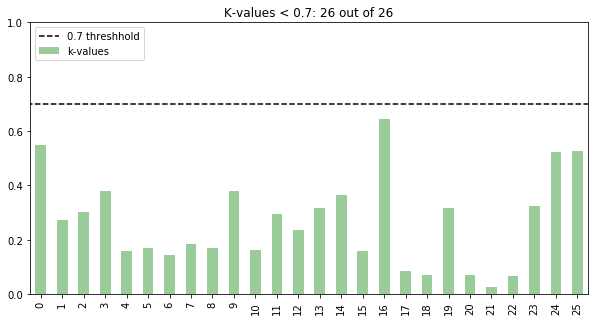

In [219]:
quality_analysis(separate_fit)

### Predictions for 2018

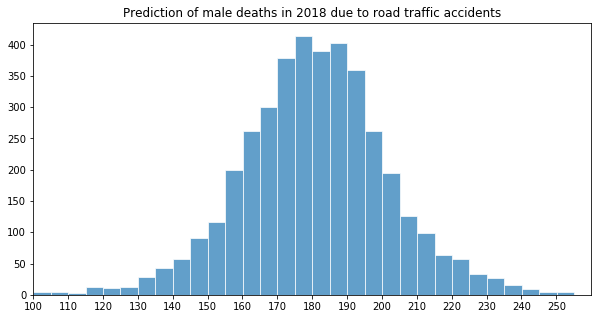

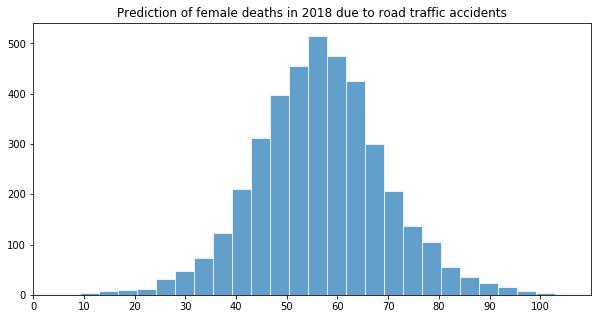

In [220]:
plot_perdiction_histogram(
    separate_fit, 
    ypred='male_pred',
    xlim=[100, 260], 
    xticks=10, 
    bins=40,
    title='Prediction of male deaths in 2018 due to road traffic accidents'
)

plot_perdiction_histogram(
    separate_fit, 
    ypred='female_pred',
    xlim=[0, 110], 
    xticks=10, 
    bins=40,
    title='Prediction of female deaths in 2018 due to road traffic accidents'
)

In [221]:
print('Prediction of male deaths in 2018:  \t {0}'.format( 
    round(np.mean(separate_fit.extract()['male_pred']))) 
 )
print('Prediction of female deaths in 2018:\t {0}'.format( 
    round(np.mean(separate_fit.extract()['female_pred']))) 
 )

Prediction of male deaths in 2018:  	 181.0
Prediction of female deaths in 2018:	 57.0


In [222]:
summary = separate_fit.summary()
summary = pd.DataFrame(summary['summary'], columns=summary['summary_colnames'], index=summary['summary_rownames'])

log_lik = separate_fit.extract(permuted=True)['log_lik']

loo, loos, ks = psisloo(log_lik)
print('PSIS-LOO value: {0}'.format(loo))

S = np.shape(log_lik)[0]
lppd = sum(np.log([1 / S * sum(np.exp(elem)) for elem in log_lik.T]))

p_loocv = lppd - loo
print('The effective number of parameters is: {0}'.format(p_loocv))

print('K-hat values: {0}'.format(ks))

summary

PSIS-LOO value: -106.80257820148955
The effective number of parameters is: 5.0006221558911506
K-hat values: [0.54943026 0.2709506  0.30311775 0.37867343 0.15809514 0.16858885
 0.14259929 0.18458384 0.16886211 0.3804126  0.16025647 0.29286016
 0.23704088 0.31751075 0.36625783 0.15904348 0.64304856 0.08391798
 0.07041451 0.31633622 0.07170445 0.0275283  0.06518011 0.32560019
 0.52261271 0.52741136]


,mean,se_mean,sd,2.5%,25%,50%,75%,97.5%,n_eff,Rhat
alpha[1],3874.138905,83.014986,2836.753386,-1944.663632,2132.356943,3905.127080,5617.190469,9308.897673,1167.697006,1.001007
alpha[2],2326.828589,63.764800,1704.615421,-1200.133664,1271.919601,2312.875901,3356.208224,5689.172071,714.645760,1.005425
beta[1],-1.830223,0.041280,1.410627,-4.532262,-2.696461,-1.846228,-0.964676,1.061853,1167.744181,1.001007
beta[2],-1.125118,0.031709,0.847668,-2.797196,-1.636887,-1.118139,-0.601086,0.629979,714.639127,1.005420
sigma[1],18.033527,0.136330,4.707376,11.732932,14.777647,17.034862,20.264820,29.880607,1192.265871,1.001079
sigma[2],10.923903,0.068661,2.925124,6.815923,8.838528,10.410367,12.374360,18.048750,1814.954056,0.999611
mu[1],204.541197,0.264473,10.000995,184.827615,198.225106,204.669081,210.629524,224.931135,1429.961065,1.000520
mu[2],202.710973,0.225300,8.842728,185.429532,197.038831,202.849086,208.099441,220.753597,1540.464373,1.000400
mu[3],200.880750,0.186674,7.768366,185.749302,195.923021,200.917348,205.579259,216.624264,1731.780031,1.000241
mu[4],199.050527,0.149511,6.817692,185.514903,194.790442,199.074680,203.171058,213.009064,2079.348207,1.000040


### Convergence diagnostics for the separate model

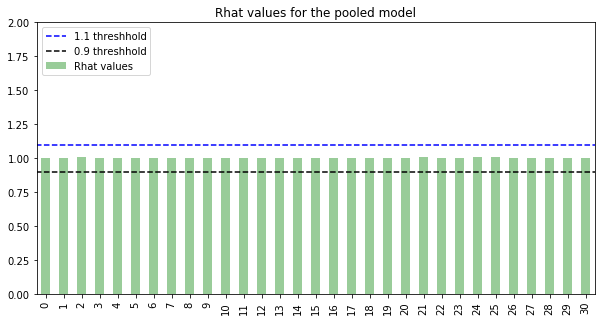

In [223]:
summary = pooled_fit.summary()
summary = pd.DataFrame(
    summary['summary'], 
    columns=summary['summary_colnames'], 
    index=summary['summary_rownames']
)

Rhat = summary['Rhat'].values

pd.Series(Rhat).plot(kind='bar', color='green', label='Rhat values', alpha=0.4)
plt.title('Rhat values for the pooled model')
plt.hlines(1.1, -1, 31, label='1.1 threshhold', linestyles='dashed', color='blue')
plt.hlines(0.9, -1, 31, label='0.9 threshhold', linestyles='dashed')
plt.ylim(0, 2)
plt.legend(loc='upper left')
plt.show()

From the histogram above, we can see that all the Rhat values are in a range between 0.9 and 1.1, which means that the model <b>has converged</b>.